In [1]:
from scipy import integrate
from scipy import stats
import random
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Simple Gene Expression Simulation
- In this section, the goal is to simulate the gene expression using simple one-dimensional ODE.

Define the differential function of protein expression based on two parameters: beta and alpha

In [2]:
def dx_dt(x, t, beta, alpha):
    return beta - alpha * x

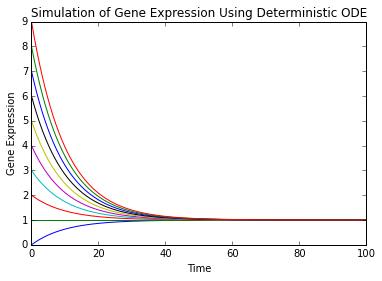

In [3]:
# time points
t = np.linspace(0, 100, 1000)

# parameters
BETA = 0.1
ALPHA = 0.1

# solve the ODE and plot the solution
fig, ax = plt.subplots(1, 1)

for x_0 in range(0, 10):
    ## solve numerically with different initial condition
    Y = integrate.odeint(dx_dt, x_0, t, args = (BETA, ALPHA))
    
    ## plot
    ax.plot(t, Y)
    ax.set_xlabel("Time")
    ax.set_ylabel("Gene Expression")
    ax.set_title("Simulation of Gene Expression Using Deterministic ODE")

- Analytical Solution

In [4]:
def solvef(t, x_0, BoverA, alpha):
    return BoverA - (BoverA - x_0) * np.e**(-alpha * t)

- Plot the solution with different BETA and ALPHA   
Steady State Concentration = production rate (BETA) / degradation rate (ALPHA)

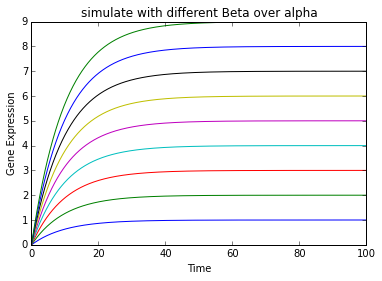

In [5]:
# set parameter
BETAoverALPHA = 1
ALPHA = 0.1
x0 = 0
t = np.linspace(0, 100, 1000)

# simulate with different Beta over alpha
for BoA in range(1, 10):
    plt.plot(t, solvef(t, x0, BoA, ALPHA))
    plt.xlabel("Time")
    plt.ylabel("Gene Expression")
    plt.title("simulate with different Beta over alpha")

- Plot the solution with different ALPHA  
ALPHA = degradation rate

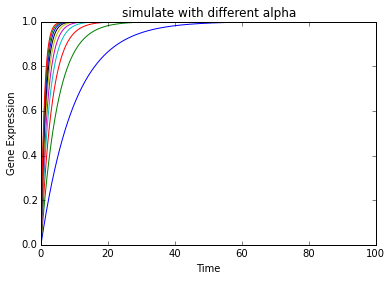

In [6]:
for alpha in np.linspace(0.1, 1, 10):
    plt.plot(t, solvef(t, x0, BETAoverALPHA, alpha))
    plt.xlabel("Time")
    plt.ylabel("Gene Expression")
    plt.title("simulate with different alpha")

# Positive Feedback Model of Two Gene Model
- In this section, the goal is to build a positive feedback model that involves two genes

After dimensionless the formula, the model is built and rewritten as the following:  
$$\frac{dx}{dt} = \frac{1}{1+y^{n_2}} - x$$
$$\frac{dy}{dt} = \frac{1}{1+x^{n_1}} - y$$

In [7]:
def dX_dt(x, y, t=0, n1=1, n2=1):
    return np.array([ 1 / (1 + y**n2) - x,
                      1 / (1 + x**n1) - y])

#def dX_dt(X, t=0, n1=1, n2=1):
#    return np.array([ 1 / (1 + X[1]**n2) - X[0],
#                      1 / (1 + X[0]**n1) - X[1]])

Quiver plot of the phase plane

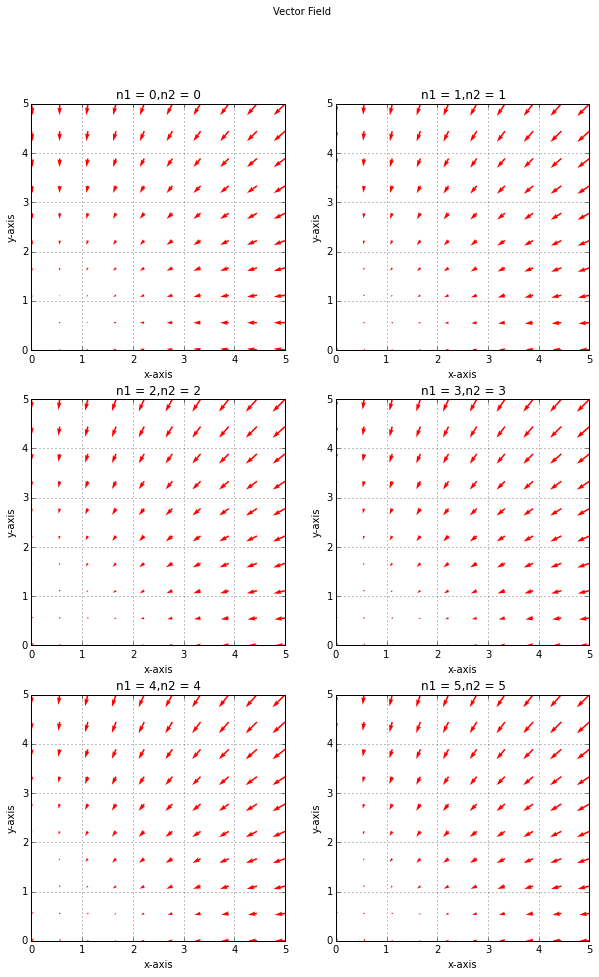

In [15]:
# set parameters
x = np.linspace(0, 5, 10)
y = np.linspace(0, 5, 10)
x, y = np.meshgrid(x, y)
n = 6
n1 = range(n)
n2 = range(n)

# Vector Field
fig, ax = plt.subplots(3, 2, figsize=(5*2, 5*3))
ax = ax.ravel()

for idx in range(n):    
    dx = dX_dt(x, y, n1=n1[idx], n2=n2[idx])[0]
    dy = dX_dt(x, y, n1=n1[idx], n2=n2[idx])[1]
    ax[idx].quiver(x, y, dx, dy, scale = 100, color = "r")

    # axis
    ax[idx].grid(True)

    # labels
    ax[idx].set_xlabel('x-axis')
    ax[idx].set_ylabel('y-axis')
    ax[idx].set_title('n1 = ' + str(n1[idx]) + ',n2 = ' + str(n2[idx]))

# title
fig.text(0.5, 0.99, 'Vector Field', horizontalalignment = 'center', verticalalignment = 'top')

# Create Gaussian Process

In [9]:
# generate Gaussian random variable from uniform distributed random variable
def gauss():
    x1 = random.random()
    x2 = random.random()
    return (-2 * math.log(x1))**0.5 * math.cos( 2 * math.pi * math.log(x2) )

In [10]:
# define the process
def process(n):
    return np.array([gauss() for dummyNum in range(n)])

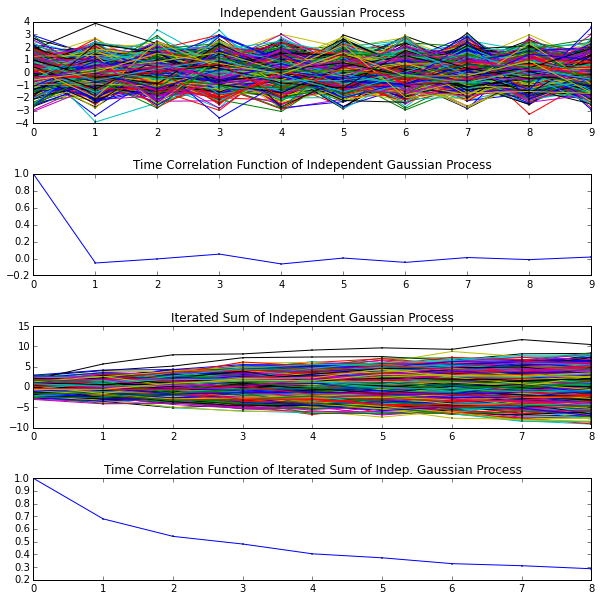

In [11]:
# create data matrix
timePointNum = 10
sampleSize = 1000

# the independent random process
result1 = np.array([process(timePointNum) for dummyNum in range(sampleSize)])

#print("Covariance")
CORR1 = np.corrcoef(result1.T)

# the random process that based on one step before
result2 = np.array([[sum(result1[sample,0:idx]) for idx in range(1, timePointNum)] for sample in range(sampleSize)])
CORR2 = np.corrcoef(result2.T)
   
# plot the process
fig, ax = plt.subplots(4, 1, figsize=(10,10))
plt.subplots_adjust(hspace = 0.5)

ax[0].plot(result1.T, '-o', markersize = 1)
ax[0].set_title("Independent Gaussian Process")
ax[0].set_xticks = np.arange(timePointNum) * 0.01

ax[1].plot(CORR1[0,:], '-o', markersize = 1)
ax[1].set_title("Time Correlation Function of Independent Gaussian Process")

ax[2].plot(result2.T, '-o', markersize = 1)
ax[2].set_title("Iterated Sum of Independent Gaussian Process")

ax[3].plot(CORR2[0,:], '-o', markersize = 1)
ax[3].set_title("Time Correlation Function of Iterated Sum of Indep. Gaussian Process")

# Gillespie Gene Expression Simulation

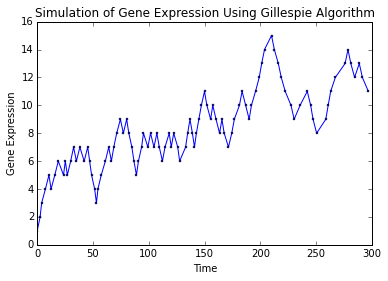

In [12]:
# set parameters
beta = 1   # transcription (txn)
alpha = 0.1  # degradation
g0 = 1    # Initial Number of molecule
t0 = 0     # time point
iterationNum = 100 # number of iterations

# simulation
g = [g0]
time = [t0]
for idx in range(iterationNum):
    probRXN_txn = beta / (beta + alpha * g[idx])
    
    # decide reaction
    dice1 = stats.bernoulli.rvs(probRXN_txn, size = 1)
    
    # Reaction occur
    if dice1 == 1:
        g.append( g[idx] + 1 ) # transcrition
    else:
        g.append( g[idx] - 1 ) # degradation
        
    # generate the time interval
    probRXN = beta + alpha * g[idx]
    interval = stats.expon.rvs(probRXN, size = 1)
    time.append( time[idx] + interval )
    
# plot the result
fig, ax = plt.subplots(1, 1)
ax.plot(time, g, '-o', markersize = 2)
ax.set_xlabel("Time")
ax.set_ylabel("Gene Expression")
ax.set_title("Simulation of Gene Expression Using Gillespie Algorithm")